In [30]:
from pydantic import BaseModel, Field
from typing_extensions import Literal, TypedDict
from pydantic import Field
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from typing import Annotated, List
import operator
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.types import Send
from IPython.display import Markdown, Image

from dotenv import load_dotenv

In [8]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

In [11]:
class SharedState(TypedDict):
    research_topic: str
    model: ChatOpenAI
    sections: list[Section]
    section_contents: Annotated[list[str], operator.add]
    final_report: str

In [12]:
def build_model(shared_state: SharedState) -> SharedState:
    shared_state['model'] = ChatOpenAI(model="gpt-4o", temperature=0)
    return shared_state

In [16]:
def orchestrator(shared_state: SharedState) -> SharedState:
    model = shared_state['model']
    orchestrator_prompt = ChatPromptTemplate.from_template(
        "Create a detailed outline for a research report on the topic of {research_topic}. "
        "Break the report down into sections, each with a name and brief description. "
        "Limit the report to at max 5 sections."
    )

    model_with_structured_output = model.with_structured_output(Sections)
    retrieval_grader = orchestrator_prompt | model_with_structured_output
    result = retrieval_grader.invoke(
        {
            "research_topic": shared_state['research_topic'],
        }
    )
    shared_state['sections'] = [section for section in result.sections]

    return shared_state


In [ ]:
load_dotenv()

shared_state = build_model({'research_topic': 'The impact of AI on modern education.'})
shared_state = orchestrator(shared_state)

shared_state['sections']

In [33]:
# Worker state
class WorkerState(TypedDict):
    section: Section
    model: ChatOpenAI
    completed_sections: Annotated[list, operator.add]

In [39]:
def worker(worker_state: WorkerState) -> SharedState:
    """Worker writes a section of the report"""
    print(f"\nWorker Spawned! Working on section: {worker_state['section'].name}")
    model = worker_state['model']
    section = worker_state['section']
    # Generate section
    section = model.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {section.name} and description: {section.description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"section_contents": [section.content]}


In [ ]:
# Conditional edge function to create llm_call workers that each write a section of the report
def spawn_workers(shared_state: SharedState):
    """Assign a worker to each section in the plan"""
    model = shared_state["model"]
    # Kick off section writing in parallel via Send() API
    return [
        Send("worker", {"section": section, "model": model}) 
        for section in shared_state["sections"]
    ]

In [38]:
def synthesizer(shared_state: SharedState):
    """Synthesize full report from sections"""

    # List of completed sections
    section_contents = shared_state["section_contents"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(section_contents)

    return {"final_report": completed_report_sections}


In [34]:
def build_workflow():
    # Build workflow
    orchestrator_worker_builder = StateGraph(SharedState)

    # Add the nodes
    orchestrator_worker_builder.add_node("build_model", build_model)
    orchestrator_worker_builder.add_node("orchestrator", orchestrator)
    orchestrator_worker_builder.add_node("worker", worker)
    orchestrator_worker_builder.add_node("synthesizer", synthesizer)

    # Add edges to connect nodes
    orchestrator_worker_builder.add_edge(START, "build_model")
    orchestrator_worker_builder.add_edge("build_model", "orchestrator")
    orchestrator_worker_builder.add_conditional_edges(
        "orchestrator", spawn_workers, ["worker"]
    )
    orchestrator_worker_builder.add_edge("worker", "synthesizer")
    orchestrator_worker_builder.add_edge("synthesizer", END)

    # Compile the workflow
    return orchestrator_worker_builder.compile()

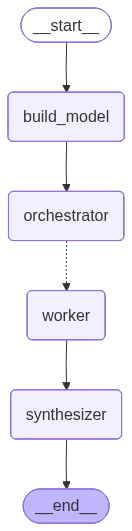

In [40]:
orchestrator_worker = build_workflow()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [41]:
state = orchestrator_worker.invoke({"research_topic": "Create a report on LLM scaling laws"})

Markdown(state["final_report"])


Worker Spawned! Working on section: Introduction to LLM Scaling Laws
Worker Spawned! Working on section: Historical Context and Development


Worker Spawned! Working on section: Theoretical Foundations of Scaling Laws

Worker Spawned! Working on section: Empirical Evidence and Case Studies

Worker Spawned! Working on section: Future Directions and Implications


## Introduction to LLM Scaling Laws

Large Language Models (LLMs) have become a cornerstone of modern artificial intelligence, driving advancements in natural language processing, machine translation, and conversational agents. These models, characterized by their vast number of parameters and extensive training datasets, have demonstrated remarkable capabilities in understanding and generating human-like text. As the field progresses, understanding the principles that govern the performance of these models becomes increasingly crucial. This is where the concept of scaling laws comes into play.

Scaling laws in the context of LLMs refer to the empirical relationships that describe how the performance of a model improves as a function of its size, the amount of data it is trained on, and the computational resources utilized. These laws provide a framework for predicting the behavior of LLMs as they are scaled up, offering insights into the trade-offs between model size, data, and compute power.

The importance of scaling laws lies in their ability to guide the development of more efficient and effective LLMs. By understanding these relationships, researchers and practitioners can make informed decisions about how to allocate resources for training and deploying models. This can lead to more cost-effective strategies for achieving desired performance levels, ultimately accelerating the pace of innovation in the field.

In this section, we will explore the foundational concepts of scaling laws and their implications for LLMs. We will discuss how these laws have been derived, the key variables involved, and the insights they provide into the future trajectory of language model development. This introduction sets the stage for a detailed analysis of scaling laws, offering a comprehensive understanding of their role in shaping the capabilities and limitations of large language models.

---

## Historical Context and Development

The development of Large Language Models (LLMs) is a fascinating journey that reflects the broader evolution of artificial intelligence and machine learning. This section explores the historical context and development of LLMs, highlighting key milestones, influential research papers, and the progression of model sizes and capabilities over time.

### Early Foundations

The roots of LLMs can be traced back to the early work on artificial neural networks and natural language processing (NLP). In the 1950s and 1960s, researchers like Frank Rosenblatt and Marvin Minsky laid the groundwork with the development of perceptrons and early neural network models. However, it wasn't until the advent of more sophisticated algorithms and increased computational power in the late 20th century that significant progress was made.

### The Emergence of Deep Learning

The 2000s marked a turning point with the resurgence of interest in neural networks, driven by the success of deep learning. The introduction of the backpropagation algorithm and the availability of large datasets enabled the training of deeper networks. In 2013, the paper "Efficient Estimation of Word Representations in Vector Space" by Mikolov et al. introduced Word2Vec, a model that revolutionized NLP by learning word embeddings, setting the stage for more complex language models.

### The Transformer Revolution

A pivotal moment in the development of LLMs came in 2017 with the introduction of the Transformer architecture by Vaswani et al. in the paper "Attention is All You Need." This architecture, which relies on self-attention mechanisms, allowed for more efficient training of language models and significantly improved performance on a variety of NLP tasks. The Transformer model became the foundation for subsequent LLMs, enabling the scaling of models to unprecedented sizes.

### Scaling Laws and Model Growth

The concept of scaling laws, which describe how model performance improves with increased size and data, became a central theme in the development of LLMs. In 2020, Kaplan et al. published "Scaling Laws for Neural Language Models," which provided empirical evidence that larger models trained on more data tend to perform better. This insight drove the development of increasingly large models, such as OpenAI's GPT-3, which boasts 175 billion parameters.

### Key Milestones and Influential Models

Several key models have marked the evolution of LLMs:

- **BERT (2018):** Developed by Google, BERT (Bidirectional Encoder Representations from Transformers) introduced a new pre-training approach that improved understanding of context in language tasks.
- **GPT-2 (2019):** OpenAI's GPT-2 demonstrated the potential of generative pre-trained transformers, showcasing impressive text generation capabilities.
- **T5 (2019):** Google's T5 (Text-to-Text Transfer Transformer) unified various NLP tasks under a single framework, further advancing the versatility of LLMs.
- **GPT-3 (2020):** With 175 billion parameters, GPT-3 set a new benchmark for LLMs, demonstrating remarkable abilities in language understanding and generation.

### Ongoing Developments

The field of LLMs continues to evolve rapidly, with ongoing research focused on improving efficiency, reducing biases, and enhancing interpretability. The development of models like OpenAI's ChatGPT and Google's LaMDA highlights the continuous push towards more capable and human-like language models.

In summary, the historical development of LLMs is characterized by a series of breakthroughs in model architecture, training techniques, and scaling laws. These advancements have collectively transformed the landscape of NLP, enabling machines to understand and generate human language with unprecedented accuracy and fluency.

---

### Theoretical Foundations of Scaling Laws

Scaling laws in large language models (LLMs) are grounded in a set of mathematical models and principles that elucidate the relationship between model size, the volume of training data, and the resulting performance. These laws provide a framework for understanding how increasing the scale of a model can enhance its capabilities, offering insights into the potential and limitations of LLMs.

#### Mathematical Models

At the core of scaling laws are power-law relationships, which describe how performance metrics such as accuracy or loss improve as a function of model size and data quantity. These relationships are often expressed in the form:

\[ P(N, D) = a \cdot N^b \cdot D^c + \epsilon \]

where \( P \) represents the performance metric, \( N \) is the number of parameters in the model, \( D \) is the amount of data, \( a \), \( b \), and \( c \) are constants derived from empirical observations, and \( \epsilon \) is an error term accounting for noise and other factors.

#### Principles of Scaling

1. **Parameter Growth**: Increasing the number of parameters in a model generally leads to improved performance, as larger models can capture more complex patterns and nuances in the data. This principle is supported by the observation that larger models tend to have lower training and validation loss, indicating better generalization capabilities.

2. **Data Scaling**: The amount of data available for training is equally crucial. As the dataset size increases, models can learn more diverse and comprehensive representations, which enhances their ability to generalize to unseen data. However, the benefits of additional data diminish as the model size grows, suggesting a saturation point where additional data yields minimal performance gains.

3. **Compute Efficiency**: The efficiency of computation plays a significant role in scaling laws. Larger models require more computational resources, and the relationship between compute and performance is often sub-linear. This means that doubling the compute does not necessarily double the performance, highlighting the importance of optimizing computational strategies.

#### Impact on LLM Capabilities

The theoretical foundations of scaling laws suggest that there is a predictable trajectory of improvement as models and datasets grow. This has profound implications for the development of LLMs, as it provides a roadmap for achieving higher performance through scaling. However, it also underscores the challenges associated with resource allocation, as the costs of scaling can be substantial.

Understanding these theoretical underpinnings allows researchers and practitioners to make informed decisions about model architecture, data collection, and resource investment, ultimately guiding the development of more powerful and efficient LLMs. As the field continues to evolve, these scaling laws will remain a critical component of the theoretical framework that drives innovation in natural language processing.

---

## Empirical Evidence and Case Studies

### Introduction

The development and deployment of large language models (LLMs) have been significantly influenced by scaling laws, which suggest that model performance improves predictably with increased model size, data, and computational resources. This section delves into empirical evidence supporting these scaling laws, drawing from a variety of experiments and real-world applications. We will explore case studies of prominent LLMs, examining both their successes and the challenges encountered during scaling.

### Empirical Evidence Supporting Scaling Laws

Recent research has consistently demonstrated that larger models tend to perform better across a range of natural language processing tasks. Studies have shown that as the number of parameters in a model increases, so does its ability to generalize and perform complex tasks. For instance, the work by Kaplan et al. (2020) provided a comprehensive analysis of scaling laws, showing that model performance scales predictably with the logarithm of the number of parameters, dataset size, and computational budget.

In another study, Brown et al. (2020) introduced GPT-3, a model with 175 billion parameters, which exhibited remarkable capabilities in few-shot learning, outperforming smaller models on various benchmarks. This empirical evidence underscores the importance of scaling in achieving state-of-the-art performance in LLMs.

### Case Studies of Prominent LLMs

#### GPT-3

GPT-3, developed by OpenAI, serves as a quintessential example of the power of scaling laws. With its massive parameter count, GPT-3 demonstrated unprecedented language understanding and generation capabilities. It excelled in tasks such as translation, question answering, and even creative writing, often requiring minimal task-specific fine-tuning. However, the model's size also posed challenges, including increased computational costs and environmental impact, highlighting the need for efficient scaling strategies.

#### BERT and its Variants

BERT (Bidirectional Encoder Representations from Transformers) and its subsequent variants, such as RoBERTa and DistilBERT, have also benefited from scaling. By increasing the model size and training data, these models have achieved superior performance on tasks like sentiment analysis and named entity recognition. The success of BERT and its derivatives illustrates the practical benefits of scaling, while also emphasizing the challenges of managing larger models, such as longer training times and the need for more sophisticated hardware.

#### T5 (Text-to-Text Transfer Transformer)

The T5 model, developed by Google Research, further exemplifies the advantages of scaling. By framing all NLP tasks as text-to-text problems, T5 leveraged scaling to achieve high performance across a wide array of tasks. The model's success in transfer learning scenarios underscores the potential of scaling to enhance model versatility and adaptability.

### Challenges in Scaling LLMs

While scaling has led to significant advancements, it also presents several challenges. The computational resources required for training and deploying large models are substantial, often limiting access to well-funded organizations. Additionally, the environmental impact of training large models has raised concerns, prompting research into more efficient training methods and architectures.

Moreover, as models grow in size, they become more opaque, complicating efforts to interpret their decision-making processes. This lack of transparency can hinder trust and accountability, particularly in sensitive applications.

### Conclusion

Empirical evidence and case studies of prominent LLMs underscore the transformative potential of scaling laws in advancing natural language processing. While the successes of models like GPT-3, BERT, and T5 highlight the benefits of scaling, the associated challenges necessitate ongoing research into efficient and sustainable scaling practices. As the field continues to evolve, balancing performance gains with ethical and practical considerations will be crucial in harnessing the full potential of LLMs.

---

## Future Directions and Implications

The future of Large Language Model (LLM) scaling laws is poised to significantly influence the trajectory of artificial intelligence research and its applications across various industries. As we continue to explore the boundaries of LLM capabilities, several potential advancements and challenges emerge, each carrying profound implications for the field.

### Advancements in LLM Scaling

1. **Enhanced Model Architectures**: Future advancements are likely to focus on refining model architectures to improve efficiency and performance. Innovations such as sparse models, which activate only a subset of parameters during inference, could lead to more scalable and cost-effective solutions.

2. **Improved Training Techniques**: Techniques like transfer learning and continual learning are expected to evolve, allowing models to leverage existing knowledge more effectively and adapt to new information with minimal retraining. This could reduce the computational resources required for training large models.

3. **Integration with Other AI Technologies**: The integration of LLMs with other AI technologies, such as reinforcement learning and computer vision, could lead to the development of more versatile and robust AI systems. This convergence may enable more complex and nuanced applications across different domains.

### Challenges in LLM Scaling

1. **Resource Constraints**: The computational and energy demands of training and deploying large-scale models remain a significant challenge. Addressing these constraints will require innovations in hardware, such as more efficient GPUs and TPUs, as well as software optimizations.

2. **Data Limitations**: The quality and diversity of training data are critical for the performance of LLMs. Ensuring access to high-quality datasets while respecting privacy and ethical considerations will be a key challenge moving forward.

3. **Model Interpretability and Bias**: As models grow in complexity, understanding their decision-making processes becomes increasingly difficult. Developing methods to interpret model outputs and mitigate biases will be essential to ensure fair and transparent AI systems.

### Implications for AI Research and Industry

1. **Accelerated Innovation**: The continued scaling of LLMs is likely to accelerate innovation in AI research, leading to breakthroughs in natural language understanding, generation, and other cognitive tasks. This could open new avenues for research and development across various scientific disciplines.

2. **Industry Applications**: In industry, LLMs have the potential to revolutionize sectors such as healthcare, finance, and customer service by automating complex tasks and providing insights from vast amounts of data. However, the deployment of these models must be carefully managed to ensure reliability and security.

3. **Ethical Considerations**: The ethical implications of LLM scaling are profound. Issues such as data privacy, algorithmic bias, and the potential for misuse must be addressed through robust governance frameworks and ethical guidelines. Ensuring that AI technologies are developed and used responsibly will be crucial for maintaining public trust.

### Trajectory of LLM Development

The trajectory of LLM development is likely to be characterized by a balance between scaling and specialization. While larger models may offer superior performance, there is a growing recognition of the need for models that are tailored to specific tasks and contexts. This shift towards more specialized models could lead to more efficient and effective AI systems that are better aligned with human values and societal needs.

In conclusion, the future of LLM scaling laws presents both exciting opportunities and formidable challenges. By navigating these complexities with foresight and responsibility, the AI community can harness the full potential of LLMs to drive progress and innovation across diverse fields.